In [1]:
import pandas as pd
import requests
import lxml.html
import numpy as np
import re
from kiwipiepy import Kiwi
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import time
import urllib
import matplotlib.pyplot as plt
import string
import re

from sklearn.decomposition import TruncatedSVD
from gensim.matutils import Sparse2Corpus
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim_models

In [2]:
hpoint_blog = pd.read_csv('naver_blog_hpoint.csv')
hpoint_cafe = pd.read_csv('naver_cafe_hpoint.csv')

* [Hpoint](#Hpoint)
    + [title](#title)
    + [context](#context)
    + [title_context](#title_context)  

# Hpoint

In [3]:
hpoint = pd.concat([ hpoint_blog, hpoint_cafe ] ).reset_index(drop = True ) ; hpoint.head()

,url,type,title,date,context
0,https://blog.naver.com/fineart1114/222766179517,naver blog,"추천 앱테크 Hpoint 지금 가입하면 7,000 포인트 혜택",2022. 6. 9. 16:56,지난 3월 앱테크에 입문해 이것저것 참 많은 앱테크를 시도해봤어요.\n그 중에서 요...
1,https://blog.naver.com/izelss/222485656911,naver blog,앱테크 hpoint 친구추천 코드 : 10545132 현대백화점웨딩마일리지 더클럽웨...,2021. 8. 27. 15:30,#앱테크 #앱테크추천\n#hpoint추천인 #hpoint친구추천코드\n#hpoint...
2,https://blog.naver.com/mimir79/222716748416,naver blog,H포인트 추천인 (10753504) HPOINT,2022. 4. 30. 21:37,"현대백화점, 현대아울렛, 현대식품관 투홈,\n그리팅, H 패션몰을 이용하는 사람이라..."
3,https://blog.naver.com/minluvsme/222023041142,naver blog,"재테크 초보의 소소한 부수입 - 앱테크 (hpoint, lpoint, 캐시워크)",2020. 7. 6. 21:20,저희 가정에 '경제부 장관'은 바로 저랍니다. 아무래도 외벌이로 가계를 꾸려나간다는...
4,https://blog.naver.com/hunimoya/222592586444,naver blog,유니버설발레단 호두까기인형 서울공연 HPoint 회원 할인 정보,2021. 12. 11. 9:00,매년 시즌에 맞춰하는 공연들이 있죠.\n가정의달 5월이나 추석쯤 하는 효도공연이나 ...


In [4]:
# 중복값 처리 
hpoint.drop_duplicates(inplace = True )

# 결측값 처리
hpoint.fillna("no_context", inplace = True)
hpoint = hpoint[hpoint["context"] != "no_context"].reset_index(drop = True)

# 특수문자 제거
hpoint["context"] = hpoint["context"].apply(lambda x: x.replace("\n", " ")).apply(lambda x:re.sub(r'[^\w\s]', '', x))

# 제목 + 내용
hpoint['title_context'] = hpoint['title'] + ' '  + hpoint['context']

In [5]:
stop_word = pd.read_csv("korean_stopwords.txt")
stop_word = stop_word.T.reset_index(drop=False).T.reset_index(drop = True)
stop_word.columns = ["token"]

In [6]:
def extract_noun(text):
    result = kiwi.analyze(text)
    stop_words = list(stop_word["token"])
    for token , pos , _ , _ in result[0][0]:
        if pos[0] in "NVI":
            if token not in stop_words:
                    if len(token) > 1:
                        yield token

## title

In [7]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(hpoint["title"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


In [8]:
hpoint_tf = word_count.sort_values("빈도",ascending = False)
hpoint_tf = hpoint_tf[hpoint_tf.빈도 >= 10]
hpoint_tf.head(10)

,단어,빈도,빈도가중치
2734,퀴즈,4115,1069.411572
2329,정답,1642,641.053275
1646,신한,1384,338.970659
2943,포인트,1130,426.716721
721,리브,884,215.974006
851,메이트,877,214.991479
3129,현대,837,347.779902
2816,테크,575,159.535587
3009,플레이,359,127.164525
2596,추천,343,99.594570


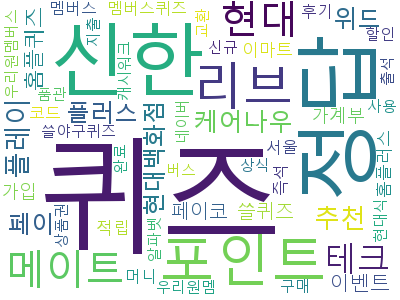

In [9]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

### LSA

In [10]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,
                  random_state=0)
svd.fit(tdm)
len(svd.components_)

print(np.shape(svd.components_))

terms = cv.get_feature_names()

def get_topics(components, feature_names, n=5) : 
    for idx, topic in enumerate(components) : # 각 토픽에 대한 주요 단어 n개 출력 
        print('Topic %d:' %(idx+1), [(feature_names[i], topic[i].round(5)) 
                    for i in topic.argsort()[:-n - 1 : -1]])
get_topics(svd.components_, terms)

(20, 3241)
Topic 1: [('퀴즈', 0.85342), ('신한', 0.29988), ('정답', 0.22949), ('리브', 0.18517), ('메이트', 0.18467)]
Topic 2: [('포인트', 0.4061), ('퀴즈', 0.32631), ('현대', 0.20645), ('정답', 0.04371), ('추천', 0.03911)]
Topic 3: [('포인트', 0.6757), ('정답', 0.38285), ('현대', 0.32446), ('신한', 0.25273), ('플레이', 0.1987)]
Topic 4: [('정답', 0.80573), ('페이코', 0.10119), ('페이', 0.09771), ('케어나우', 0.0676), ('케어', 0.04827)]
Topic 5: [('추천', 0.43512), ('테크', 0.38863), ('플러스', 0.18697), ('케어나우', 0.1738), ('신한', 0.15507)]
Topic 6: [('추천', 0.4167), ('테크', 0.33691), ('리브', 0.30314), ('메이트', 0.29966), ('페이', 0.18223)]
Topic 7: [('포인트', 0.37618), ('이마트', 0.19205), ('머니', 0.19112), ('즉석', 0.18891), ('우리원멤', 0.16668)]
Topic 8: [('추천', 0.59128), ('멤버스퀴즈', 0.25768), ('정답', 0.16352), ('현대', 0.15599), ('홈플러스', 0.15045)]
Topic 9: [('멤버스퀴즈', 0.42969), ('페이', 0.35913), ('쏠퀴즈', 0.35262), ('적립', 0.22676), ('멤버스', 0.22153)]
Topic 10: [('현대백화점', 0.55635), ('테크', 0.19054), ('이마트', 0.18218), ('멤버스퀴즈', 0.18075), ('머니', 0.18067)]
Topic 11: [(

### LDA

In [11]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)

def tokenizer(text):
    words = []
    stop_words = list(stop_word["token"])
    for word in token_re.findall(text):
        if word not in stop_words:
            words.append(word)
    return words

docs = []
for text in hpoint["title"]:
    doc = tokenizer(text)
    docs.append(doc)
    
dic = Dictionary(docs)
dic.filter_extremes(no_below=10, no_above=0.9)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
    
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=5432)

In [12]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-8.065449856131744
-7.616318224786612
-7.454045076700849
-7.387182526354439


In [16]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dic, sort_topics=False)
pyLDAvis.display(p) 

C:\Users\USER\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


퀴즈
- 오늘의 퀴즈를 맞추면 포인트 적립
- 신한플러스, 쏠퀴즈, 리브메이트, 우리won멤버스, hpoint, 케어나우, NH멤버스, 홈플러스 모두 퀴즈 진행
- 앱테크 일종

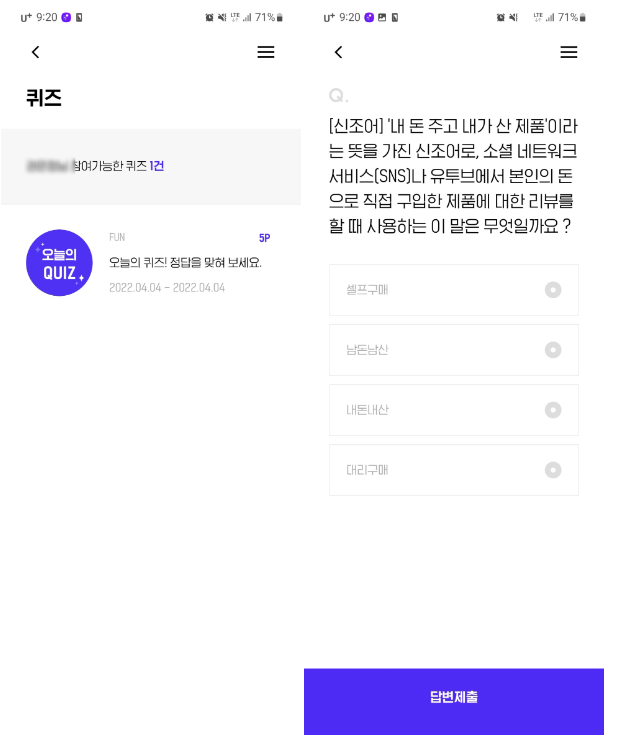

In [17]:
model.get_term_topics(dic.token2id['퀴즈'], 0.01)

[(2, 0.06965246),
 (6, 0.1398327),
 (10, 0.11618681),
 (13, 0.067117296),
 (17, 0.24752809),
 (22, 0.07251553),
 (23, 0.062150892),
 (25, 0.07804588),
 (26, 0.43235487),
 (28, 0.040263504),
 (31, 0.12396173),
 (35, 0.2513869),
 (37, 0.1332609),
 (40, 0.20673001),
 (45, 0.040402494),
 (46, 0.19823892),
 (48, 0.08716014),
 (49, 0.18797222),
 (50, 0.02010421),
 (52, 0.13606817),
 (54, 0.2780948),
 (55, 0.06063846),
 (56, 0.21652736),
 (58, 0.07409168),
 (61, 0.2530152),
 (64, 0.25274616),
 (66, 0.07918859),
 (76, 0.22600593),
 (77, 0.010483063),
 (83, 0.10167835),
 (90, 0.13639718),
 (91, 0.16553083),
 (92, 0.030767018),
 (93, 0.05739029),
 (97, 0.109006196),
 (99, 0.047903597)]

In [19]:
model.show_topic(61)

[('퀴즈', 0.25311506),
 ('신한플러스', 0.06446877),
 ('신한', 0.06422251),
 ('위드', 0.06393427),
 ('OX퀴즈', 0.06390218),
 ('Point', 0.06388723),
 ('정답_케어나우', 0.06379349),
 ('With', 0.06379263),
 ('리브메이트', 0.06346057),
 ('오늘의', 0.06325902)]

In [20]:
hpoint[hpoint['title'].str.contains('퀴즈') ]['title']

5                H point 앱테크 :: HPOINT 퀴즈, 사용, H포인트 전환까지!
16                                      hpoint 퀴즈 정답 7월5일
21      7월 1일 오늘의퀴즈 정답(리브메이트, 신한쏠, 야구, 우리원멤버스, hpoint,...
25                  12월19일 오늘의 앱테크 퀴즈정답 및 HPOINT 퀴즈이벤트 소개
27      <6월 22일> 앱테크 퀴즈 정답 (HPOINT 케어나우 신한 쏠퀴즈 ox퀴즈 리브...
                              ...                        
4800                                         hpoint 퀴즈 정답
4807                                        'HPOINT 퀴즈 정답
4808                                         Hpoint 퀴즈 정답
4824                       hpoint 퀴즈 3월 10일 정답 갤러리형/ mz세대
4935                                             더현대퀴즈 정답
Name: title, Length: 2350, dtype: object

In [21]:
hpoint.iloc[5,:]

url                   https://blog.naver.com/nancy_jh/222691715390
type                                                    naver blog
title                     H point 앱테크 :: HPOINT 퀴즈, 사용, H포인트 전환까지!
date                                             2022. 4. 4. 22:42
context          H point 앱테크  HPOINT 퀴즈 HPOINT사용 H포인트 퀴즈 h포인트 전...
title_context    H point 앱테크 :: HPOINT 퀴즈, 사용, H포인트 전환까지! H poi...
Name: 5, dtype: object

In [24]:
hpoint[hpoint['title'].str.contains('멤버스퀴즈') ]['title']

178     [22년07월04일] 22/07/04- 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리wo...
203     [22년07월02일] 22/07/02- 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리wo...
236     [22년07월03일] 22/07/03- 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리wo...
238     [22년07월05일] 22/07/05- 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리wo...
284     [22년07월01일] 22/07/01- 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리wo...
                              ...                        
1117    [10월08일] 10/08 - 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리won멤버스퀴...
1118    [10월18일] 10/18 - 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리won멤버스퀴...
1119    [10월16일] 10/16 - 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리won멤버스퀴...
1120    [10월15일] 10/15 - 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리won멤버스퀴...
1122    [10월10일] 10/10 - 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리won멤버스퀴...
Name: title, Length: 72, dtype: object

In [25]:
hpoint.iloc[178,:]

url                   https://blog.naver.com/ajjang82/222799272228
type                                                    naver blog
title            [22년07월04일] 22/07/04- 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리wo...
date                                              2022. 7. 4. 7:59
context          신한 플레이 추천코드 5BF075A 가입자 스벅커피  추천인 1000point 신한...
title_context    [22년07월04일] 22/07/04- 신한플러스퀴즈,쏠퀴즈,리브메이트퀴즈,우리wo...
Name: 178, dtype: object

맥포머스

In [26]:
hpoint[hpoint['title'].str.contains('맥포머스') ]['title']

1402                <맥포머스 브레인 에볼루션> 방송안내 (02/15 현대홈쇼핑 방송)
1411                <맥포머스 브레인 에볼루션> 방송안내 (02/22 현대홈쇼핑 방송)
1443                <맥포머스 브레인 에볼루션> 방송안내 (02/26 현대홈쇼핑 방송)
1467                <맥포머스 브레인 에볼루션> 방송안내 (01/24 현대홈쇼핑 방송)
1498                <맥포머스 브레인 에볼루션> 방송안내 (01/15 현대홈쇼핑 방송)
1590                  <맥포머스 브레인 에볼루션> 방송안내 (9/25현대홈쇼핑 방송)
1597                <맥포머스 브레인 에볼루션> 방송안내 (02/09 현대홈쇼핑 방송)
1635    [8월 12일 방송안내] 넘치는 혜택! 맥포머스 매직월드 코딩 특별 패키지 현대 홈...
1636                 <맥포머스 브레인 에볼루션> 첫방송안내 (9/13현대홈쇼핑 방송)
1646                           맥포머스 '브레인에볼루션' 신제품 출시 이벤트!
1660    <맥포머스 브레인 에볼루션 크리스마스 특별 패키지> 방송안내 (12/16,12/17...
1900    <맥포머스 브레인 에볼루션 크리스마스 특별 패키지> 방송안내 (12/20 현대홈쇼핑...
1957    <맥포머스 브레인 에볼루션 크리스마스 특별 패키지> 방송안내 (12/18 현대홈쇼핑...
2055            맥포머스 다이내믹 브레인 크리스마스 특별패키지 현대 홈쇼핑 첫 방송 안내!
2145    [공지] <맥포머스 브레인 에볼루션 크리스마스 특별 패키지> 방송안내 (12/24 ...
2200    * 맥포머스 신제품 홈쇼핑안내 * 2019 NEW 다이내믹 브레인 키즈페스티벌 특집...
2208    <맥포머스 브레인 에볼루션 크리스마스 특별 패키지> 방송안내 (12/28 현대홈쇼핑...
2217          

가계부

In [28]:
model.get_term_topics(dic.token2id['가계부'], 0.01)

[(12, 0.57805365), (51, 0.086925425)]

In [29]:
model.show_topic(12)

[('가계부', 0.5782632),
 ('공유', 0.37762985),
 ('결산', 0.020481555),
 ('생활비', 0.020093296),
 ('3월', 8.649617e-05),
 ('26', 4.9667287e-05),
 ('퀴즈', 4.487021e-05),
 ('feat', 4.3874534e-05),
 ('1만원', 2.5767318e-05),
 ('hpoint', 1.9206173e-05)]

In [30]:
model.show_topic(51)

[('짠테크', 0.27020586),
 ('적립금', 0.18657476),
 ('뭉푸푸', 0.18570082),
 ('더현대닷컴', 0.18395604),
 ('가계부', 0.08893471),
 ('01', 0.054428194),
 ('16', 0.0057675713),
 ('hpoint', 0.003289234),
 ('사용', 0.0019935311),
 ('feat', 0.0019691773)]

In [27]:
hpoint[hpoint['title'].str.contains('가계부') ]['title']

485     [3인가족 한달생활비 30만원]지출 가계부(feat.hpoint, 서울식품몰, 우동마트)
1000               [알뜰한 가계부] 7/14 맥도날드/스타벅스/GSshop/Hpoint
1003            5월 29일 가계부: hpoint, 락앤락몰, 미구하라 털기 쇼핑의 날!!
1187                              새로운 마음으로 시작하는 1월 1주 가계부
1336                    신혼부부 가계부 5월 4주 주간 결산(2인가구 생활비 공유)
                              ...                        
4960                                         20211027 가계부
4986                       (쏘아) 소소하지만 행복한 가계부 3.11 / h포인트
4995                                        데이라이트 11월 가계부
5007                                        데이라이트 11월 가계부
5019                                        데이라이트 11월 가계부
Name: title, Length: 138, dtype: object

## context

In [32]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(hpoint["context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


In [33]:
hpoint_tf = word_count.sort_values("빈도",ascending = False)
hpoint_tf = hpoint_tf[hpoint_tf.빈도 >= 10]
hpoint_tf.head(10)

,단어,빈도,빈도가중치
4234,퀴즈,19480,826.053803
4546,포인트,13926,379.329975
3586,정답,11273,568.883566
4028,추천,5856,183.217668
3517,적립,5239,142.240536
2530,신한,4888,306.456592
4832,현대,4001,147.227246
39,가입,3994,117.876408
3269,이벤트,3964,128.859543
4200,코드,3855,121.873902


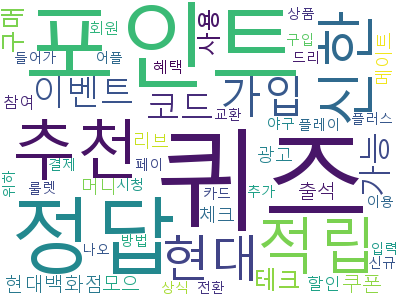

In [34]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

### LSA

In [35]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,
                  random_state=0)
svd.fit(tdm)
len(svd.components_)

print(np.shape(svd.components_))

terms = cv.get_feature_names()

def get_topics(components, feature_names, n=5) : 
    for idx, topic in enumerate(components) : # 각 토픽에 대한 주요 단어 n개 출력 
        print('Topic %d:' %(idx+1), [(feature_names[i], topic[i].round(5)) 
                    for i in topic.argsort()[:-n - 1 : -1]])
get_topics(svd.components_, terms)

(20, 5000)
Topic 1: [('포인트', 0.5018), ('퀴즈', 0.44481), ('추천', 0.31857), ('정답', 0.25737), ('적립', 0.25699)]
Topic 2: [('추천', 0.2353), ('포인트', 0.20363), ('가입', 0.18699), ('가능', 0.12137), ('적립', 0.11656)]
Topic 3: [('부동산', 0.45255), ('공부', 0.32257), ('데이터', 0.2544), ('블로그', 0.2494), ('투자', 0.23632)]
Topic 4: [('광고', 0.45918), ('머니', 0.41888), ('시청', 0.29884), ('코드', 0.2665), ('이마트', 0.17966)]
Topic 5: [('추천', 0.45402), ('코드', 0.24951), ('가입', 0.19989), ('정답', 0.12436), ('적립', 0.11795)]
Topic 6: [('냉장고', 0.28486), ('캠핑', 0.2844), ('사용', 0.19227), ('댓글', 0.19081), ('구매', 0.16314)]
Topic 7: [('냉장고', 0.3292), ('캠핑', 0.32712), ('포인트', 0.23321), ('댓글', 0.19828), ('리터', 0.16087)]
Topic 8: [('호텔', 0.31897), ('올리', 0.30205), ('게시판', 0.26774), ('프로모션', 0.26118), ('프로', 0.16708)]
Topic 9: [('현대', 0.36361), ('정답', 0.28481), ('서울', 0.23897), ('현대백화점', 0.15688), ('포인트', 0.14072)]
Topic 10: [('정답', 0.4636), ('가능', 0.2528), ('전환', 0.24125), ('사용', 0.16403), ('문화', 0.15511)]
Topic 11: [('적립', 0.34293), ('퀴

### LDA

In [36]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)

def tokenizer(text):
    words = []
    stop_words = list(stop_word["token"])
    for word in token_re.findall(text):
        if word not in stop_words:
            words.append(word)
    return words

docs = []
for text in hpoint["context"]:
    doc = tokenizer(text)
    docs.append(doc)
    
dic = Dictionary(docs)
dic.filter_extremes(no_below=10, no_above=0.9)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
    
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=5432)

In [37]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-10.168323997853982
-9.52451294831175
-9.29123053074107
-9.179634324269394
-9.11635129377264


In [38]:
model.get_term_topics(dic.token2id['포인트'], 0.01)

[(12, 0.026518092),
 (17, 0.0126068415),
 (19, 0.022259891),
 (30, 0.020067949),
 (31, 0.011524559),
 (38, 0.017809628),
 (41, 0.030143104),
 (44, 0.028728345),
 (45, 0.02533026),
 (47, 0.029201325),
 (57, 0.024682904),
 (63, 0.020244844),
 (64, 0.012530339),
 (72, 0.027364),
 (80, 0.040951714),
 (86, 0.034696337),
 (89, 0.026494354),
 (92, 0.013644116),
 (97, 0.014231291),
 (98, 0.0254784)]

In [39]:
model.show_topic(80)

[('앱테크', 0.045737695),
 ('포인트', 0.040975023),
 ('스벅', 0.030684397),
 ('기본', 0.023734188),
 ('1달', 0.023675311),
 ('추천인', 0.016209515),
 ('앱테크로', 0.013927825),
 ('출석체크', 0.0132272225),
 ('있어요', 0.012717787),
 ('모은', 0.010664125)]

In [40]:
model.show_topic(10)

[('hpoint', 0.020769913),
 ('이벤트', 0.016245427),
 ('컬쳐캐쉬', 0.0127743315),
 ('식품', 0.0126378955),
 ('있는', 0.012116426),
 ('되세요', 0.011678339),
 ('문화상품권으로', 0.011650237),
 ('없네요', 0.011515435),
 ('장을', 0.011306424),
 ('만드는', 0.010227923)]

In [41]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dic, sort_topics=False)
pyLDAvis.display(p) 

C:\Users\USER\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [43]:
hpoint[hpoint['context'].str.contains('출석') ]['context']

0       지난 3월 앱테크에 입문해 이것저것 참 많은 앱테크를 시도해봤어요 그 중에서 요긴하...
1       앱테크 앱테크추천 hpoint추천인 hpoint친구추천코드 hpoint추천인 현대백...
3       저희 가정에 경제부 장관은 바로 저랍니다 아무래도 외벌이로 가계를 꾸려나간다는 것이...
5       H point 앱테크  HPOINT 퀴즈 HPOINT사용 H포인트 퀴즈 h포인트 전...
6       어제 운동하고 오면서 만보걷기하고 포인트를 적립하는데 대체 하루동안 얼마나 모아지는...
                              ...                        
4934    초보가 왕초보에게 팁을 주는 세상입니다 저도 시작한지 2달 된 초보이지만 처음 시작...
4952    안녕하세요 가계부 방에서 활동하고 있는 부자알로하입니다   저는 가입한지는 얼마 안...
5001    심심하면 깔아놓은 앱 이벤트 들어가는게 취미임돠  마침 H패션몰에서 출첵 이벤트를 ...
5013              출석하는방법이요 빠짐없이하려면요  어플 다운받아놓고  꾸준히들어가시나여
5021              출석하는방법이요 빠짐없이하려면요  어플 다운받아놓고  꾸준히들어가시나여
Name: context, Length: 716, dtype: object

## title_context

In [55]:
kiwi = Kiwi()
kiwi.prepare()

cv = CountVectorizer(max_features = 5000 , tokenizer = extract_noun)
trans = TfidfTransformer()
tdm =cv.fit_transform(hpoint["title_context"])
tfidf = trans.fit_transform(tdm)
word_count=pd.DataFrame({
    "단어" : cv.get_feature_names(),
    "빈도" : tdm.sum(axis = 0).flat,
    "빈도가중치" : tfidf.sum(axis =0).flat })

C:\Users\USER\anaconda3\lib\site-packages\kiwipiepy\_wrap.py:612: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
  warnings.warn(


In [56]:
hpoint_tf = word_count.sort_values("빈도",ascending = False)
hpoint_tf = hpoint_tf[hpoint_tf.빈도 >= 10]
hpoint_tf.head(10)

,단어,빈도,빈도가중치
4229,퀴즈,23488,907.347941
4549,포인트,15059,402.489971
3587,정답,12912,567.972899
2537,신한,6216,347.738741
4025,추천,6199,186.982455
3520,적립,5358,142.215457
4837,현대,4846,186.309659
38,가입,4145,117.025148
3272,이벤트,4144,129.762275
4196,코드,3940,117.931568


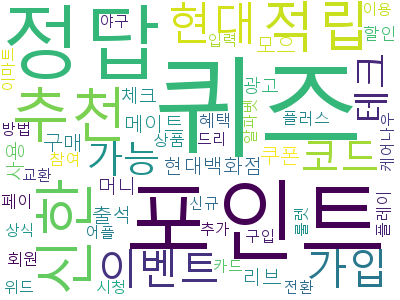

In [57]:
from wordcloud import WordCloud

wc = WordCloud(font_path='C:/Windows/Fonts/Malgun.ttf',
               background_color='white',
               max_words=50,
               width=400, height=300)
count_dic = dict(zip(word_count['단어'] , word_count['빈도']))
cloud = wc.generate_from_frequencies(count_dic) ; cloud.to_image()

### LSA

In [58]:
svd = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100,
                  random_state=0)
svd.fit(tdm)
len(svd.components_)

print(np.shape(svd.components_))

terms = cv.get_feature_names()

def get_topics(components, feature_names, n=5) : 
    for idx, topic in enumerate(components) : # 각 토픽에 대한 주요 단어 n개 출력 
        print('Topic %d:' %(idx+1), [(feature_names[i], topic[i].round(5)) 
                    for i in topic.argsort()[:-n - 1 : -1]])
get_topics(svd.components_, terms)

(20, 5000)
Topic 1: [('퀴즈', 0.56754), ('포인트', 0.45174), ('정답', 0.30846), ('추천', 0.27126), ('적립', 0.22293)]
Topic 2: [('포인트', 0.32651), ('추천', 0.2861), ('가입', 0.21251), ('적립', 0.16372), ('가능', 0.14387)]
Topic 3: [('부동산', 0.46333), ('공부', 0.3325), ('데이터', 0.25864), ('블로그', 0.25424), ('투자', 0.24071)]
Topic 4: [('광고', 0.43537), ('머니', 0.41858), ('시청', 0.28253), ('코드', 0.26885), ('이마트', 0.19243)]
Topic 5: [('추천', 0.44617), ('코드', 0.23582), ('가입', 0.20957), ('적립', 0.11689), ('신한', 0.11588)]
Topic 6: [('캠핑', 0.22222), ('냉장고', 0.21865), ('현대', 0.21122), ('구매', 0.194), ('사용', 0.19081)]
Topic 7: [('캠핑', 0.37597), ('냉장고', 0.37162), ('댓글', 0.22895), ('리터', 0.18316), ('포인트', 0.16951)]
Topic 8: [('호텔', 0.32942), ('올리', 0.31637), ('게시판', 0.27669), ('프로모션', 0.26679), ('프로', 0.1675)]
Topic 9: [('정답', 0.3693), ('현대', 0.32837), ('서울', 0.19346), ('현대백화점', 0.10737), ('코드', 0.10532)]
Topic 10: [('정답', 0.44212), ('전환', 0.27959), ('가능', 0.23633), ('문화', 0.1953), ('사용', 0.18086)]
Topic 11: [('적립', 0.26602), ('

### LDA

In [59]:
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE)

def tokenizer(text):
    words = []
    stop_words = list(stop_word["token"])
    for word in token_re.findall(text):
        if word not in stop_words:
            words.append(word)
    return words

docs = []
for text in hpoint["title_context"]:
    doc = tokenizer(text)
    docs.append(doc)
    
dic = Dictionary(docs)
dic.filter_extremes(no_below=10, no_above=0.9)

corpus = []
for doc in docs:
    bow = dic.doc2bow(doc)
    corpus.append(bow)
    
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.2, random_state=5432)

In [60]:
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,
    num_topics=100,
    random_state=1234)

old_loss = -np.inf
loss = model.log_perplexity(valid_corpus)

while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-9.889355338907336
-9.274596738042591
-9.058657620688741
-8.955884634259368
-8.899182491086878


In [61]:
model.get_term_topics(dic.token2id['포인트'], 0.01)

[(1, 0.022447618),
 (6, 0.013049749),
 (27, 0.023162214),
 (28, 0.02535762),
 (30, 0.038937792),
 (31, 0.015620738),
 (40, 0.032802403),
 (41, 0.0100036),
 (51, 0.02183379),
 (52, 0.04197178),
 (53, 0.0510507),
 (54, 0.011702227),
 (57, 0.01345527),
 (58, 0.017123252),
 (63, 0.021212125),
 (65, 0.019532042),
 (71, 0.02937353),
 (78, 0.028163891),
 (79, 0.026770562),
 (80, 0.027311878),
 (89, 0.029516252)]

In [39]:
model.show_topic(80)

[('앱테크', 0.045737695),
 ('포인트', 0.040975023),
 ('스벅', 0.030684397),
 ('기본', 0.023734188),
 ('1달', 0.023675311),
 ('추천인', 0.016209515),
 ('앱테크로', 0.013927825),
 ('출석체크', 0.0132272225),
 ('있어요', 0.012717787),
 ('모은', 0.010664125)]

In [35]:
model.show_topic(10)

[('hpoint', 0.020769913),
 ('이벤트', 0.016245427),
 ('컬쳐캐쉬', 0.0127743315),
 ('식품', 0.0126378955),
 ('있는', 0.012116426),
 ('되세요', 0.011678339),
 ('문화상품권으로', 0.011650237),
 ('없네요', 0.011515435),
 ('장을', 0.011306424),
 ('만드는', 0.010227923)]

In [40]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model, corpus, dic, sort_topics=False)
pyLDAvis.display(p) 